In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import xgboost as xgb

In [2]:
def metric(y_true, y_pred, types, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [3]:
df = dict()

df['train'] = pd.read_csv('../input/train.csv', index_col='id')
df['infer'] = pd.read_csv('../input/test.csv', index_col='id')
df['structure'] = pd.read_csv('../input/structures.csv')
df['charges'] = pd.read_csv('../input/mulliken_charges.csv')

# merge both datasets
df['full'] = pd.concat([df['train'], df['infer']], axis=0, sort=False)

# free up some memory
del df['train'], df['infer']

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
# feature engineering

key = 'full'

for atom in [0,1]:

    # adding atom coordinates
    df[key] = pd.merge(df[key], df['structure'], how = 'left',
                        left_on  = ['molecule_name', f'atom_index_{atom}'],
                        right_on = ['molecule_name',  'atom_index'], 
                    )

    df[key] = df[key].drop('atom_index', axis=1)
    df[key] = df[key].rename(columns={
                            'atom': f'A{atom}',
                            'x': f'x{atom}',
                            'y': f'y{atom}',
                            'z': f'z{atom}'})

# adding number of atoms in a molecule
df[key] = pd.merge(df[key], pd.DataFrame(df['structure'].groupby('molecule_name')['atom_index'].max()), how='left',
                   left_on='molecule_name', right_on='molecule_name')
df[key] = df[key].rename(columns={'atom_index' : 'nAtoms'})

# adding bond type
df[key].loc[:, 'bond'] = [value[:2] for value in df[key]['type'].values]

# adding atom pair
df[key].loc[:, 'pair'] = [value[2:] for value in df[key]['type'].values]

# adding distances between atoms
df[key]['L2'] = np.linalg.norm(df[key][['x0', 'y0', 'z0']].values - \
                               df[key][['x1', 'y1', 'z1']].values, ord=2, axis=1)
df[key]['L1'] = np.linalg.norm(df[key][['x0', 'y0', 'z0']].values - \
                               df[key][['x1', 'y1', 'z1']].values, ord=1, axis=1)

# adding distance components between atoms
df[key].loc[:, 'dx'] = np.abs(df[key].loc[:, 'x0'] - df[key].loc[:, 'x1'])
df[key].loc[:, 'dy'] = np.abs(df[key].loc[:, 'y0'] - df[key].loc[:, 'y1'])
df[key].loc[:, 'dz'] = np.abs(df[key].loc[:, 'z0'] - df[key].loc[:, 'z1'])

# adding relative (to the molecule) L1/L2 distance
df[key].loc[:, 'L1_RM'] = df[key].loc[:, 'L1'] / df[key].groupby('molecule_name')['L1'].transform('max')
df[key].loc[:, 'L2_RM'] = df[key].loc[:, 'L2'] / df[key].groupby('molecule_name')['L2'].transform('max')

# adding relative (to the atom) L1/L2 distance
df[key].loc[:, 'L1_RA'] = df[key].loc[:, 'L1'] / df[key].groupby('A1')['L1'].transform('max')
df[key].loc[:, 'L2_RA'] = df[key].loc[:, 'L2'] / df[key].groupby('A1')['L2'].transform('max')

# adding relative (to the bond) L1/L2 distance
df[key].loc[:, 'L1_RB'] = df[key].loc[:, 'L1'] / df[key].groupby('bond')['L1'].transform('max')
df[key].loc[:, 'L2_RB'] = df[key].loc[:, 'L2'] / df[key].groupby('bond')['L2'].transform('max')

# adding relative (to the type) L1/L2 distance
df[key].loc[:, 'L1_RT'] = df[key].loc[:, 'L1'] / df[key].groupby('type')['L1'].transform('max')
df[key].loc[:, 'L2_RT'] = df[key].loc[:, 'L2'] / df[key].groupby('type')['L2'].transform('max')

# adding molecule reference volume
volumes = np.prod(df['structure'].groupby('molecule_name')[['x','y','z']].max() - \
                  df['structure'].groupby('molecule_name')[['x','y','z']].min(), axis=1)

volumes = pd.DataFrame(volumes)

df[key] = pd.merge(df[key], volumes, how='left', left_on='molecule_name', right_index=True)
df[key] = df[key].rename(columns={0 : 'volume'})

del volumes

# adding molecule reference sizes
size = df['structure'].groupby('molecule_name')[['x','y','z']].max() - \
       df['structure'].groupby('molecule_name')[['x','y','z']].min()

size = pd.DataFrame(size)

df[key] = pd.merge(df[key], size, how='left', left_on='molecule_name', right_index=True)
df[key] = df[key].rename(columns={'x':'Lx', 'y':'Ly', 'z':'Lz'})

del size

# adding molecule weights
atomic_weights = {
    'H' : 1.008,
    'C' : 12.011,
    'N' : 14.007,
    'O' : 15.999,
    'F' : 18.998
}

def weight(element):
    return atomic_weights[element]

df['structure'].loc[:, 'atomic_weight'] = list(map(weight, df['structure']['atom']))

weights = df['structure'].groupby('molecule_name')['atomic_weight'].sum()
weights = pd.DataFrame(weights)

df[key] = pd.merge(df[key], weights, how='left', left_on='molecule_name', right_index=True)
df[key] = df[key].rename(columns={'atomic_weight' : 'weight'})

del weights

# adding individual atomic weights
df[key].loc[:, 'weightAtom'] = list(map(weight, df[key]['A1']))

# adding some feature crosses
df[key].loc[:, 'wA/w'] = df[key].loc[:, 'weightAtom'] / df[key].loc[:, 'weight'] 
df[key].loc[:, 'L1/Lx'] = df[key].loc[:, 'L1'] / df[key].loc[:, 'Lx']
df[key].loc[:, 'L2/Lx'] = df[key].loc[:, 'L2'] / df[key].loc[:, 'Lx']
df[key].loc[:, 'L1/Ly'] = df[key].loc[:, 'L1'] / df[key].loc[:, 'Ly']
df[key].loc[:, 'L2/Ly'] = df[key].loc[:, 'L2'] / df[key].loc[:, 'Ly']
df[key].loc[:, 'L1/Lz'] = df[key].loc[:, 'L1'] / df[key].loc[:, 'Lz']
df[key].loc[:, 'L2/Lz'] = df[key].loc[:, 'L2'] / df[key].loc[:, 'Lz']
df[key].loc[:, 'dx/Lx'] = df[key].loc[:, 'dx'] / df[key].loc[:, 'Lx']
df[key].loc[:, 'dy/Ly'] = df[key].loc[:, 'dy'] / df[key].loc[:, 'Ly']
df[key].loc[:, 'dz/Lz'] = df[key].loc[:, 'dz'] / df[key].loc[:, 'Lz']
df[key].loc[:, 'dx/Lx_RB'] = df[key].loc[:, 'dx'] / df[key].groupby('bond')['Lx'].transform('max')
df[key].loc[:, 'dy/Ly_RB'] = df[key].loc[:, 'dy'] / df[key].groupby('bond')['Ly'].transform('max')
df[key].loc[:, 'dz/Lz_RB'] = df[key].loc[:, 'dz'] / df[key].groupby('bond')['Lz'].transform('max')

In [5]:
encoder = LabelEncoder()
for feature in ['type', 'bond', 'pair']:
    df['full'][feature] = encoder.fit_transform(df['full'][feature])

In [6]:
X, y = dict(), dict()

to_drop = [
    'A0', 'A1', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'weightAtom', 'scalar_coupling_constant'
]

X['train'] = df['full'][df['full']['scalar_coupling_constant'].isna() == False].drop(to_drop, axis=1)
X['infer'] = df['full'][df['full']['scalar_coupling_constant'].isna() == True].drop(to_drop, axis=1)

y['train'] = df['full'][df['full']['scalar_coupling_constant'].isna() == False]['scalar_coupling_constant']

X['train'], X['valid'], y['train'], y['valid'] = train_test_split(X['train'], y['train'], 
                                                                  random_state=0, test_size=0.2)

del df['full']

In [7]:
for key in ['train', 'valid']:
    X[key] = pd.merge(X[key], df['charges'], how='left',
             left_on=['molecule_name', 'atom_index_0'], right_on=['molecule_name', 'atom_index'])

    X[key] = X[key].rename(columns={'mulliken_charge':'M0'})

    X[key] = pd.merge(X[key], df['charges'], how='left',
             left_on=['molecule_name', 'atom_index_1'], right_on=['molecule_name', 'atom_index'])

    X[key] = X[key].rename(columns={'mulliken_charge':'M1'})

    X[key].drop(['atom_index_x', 'atom_index_y'], axis=1, inplace=True)

In [8]:
print('{}, {}, {}'.format(X['train'].shape, X['valid'].shape, X['infer'].shape))

(3726517, 40), (931630, 40), (2505542, 38)


In [9]:
for key in ['train', 'valid', 'infer']:
    X[key].drop(['molecule_name', 'atom_index_0', 'atom_index_1'], axis=1, inplace=True)

In [10]:
# building model for M0
model0 = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.2,
    max_depth = 9,
    n_jobs=-1,
    random_state=0,
    subsample=0.8,
    tree_method='gpu_hist'
)

to_drop = ['M0', 'M1']

model0.fit(
    X['train'].drop(to_drop,axis=1), X['train']['M0'], 
    eval_set=[(X['valid'].drop(to_drop,axis=1), X['valid']['M0'])], 
    eval_metric='mae',early_stopping_rounds=20)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-mae:0.302339
Will train until validation_0-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:0.241872
[2]	validation_0-mae:0.193498
[3]	validation_0-mae:0.155003
[4]	validation_0-mae:0.124891
[5]	validation_0-mae:0.10135
[6]	validation_0-mae:0.082837
[7]	validation_0-mae:0.068092
[8]	validation_0-mae:0.056371
[9]	validation_0-mae:0.047004
[10]	validation_0-mae:0.039628
[11]	validation_0-mae:0.033889
[12]	validation_0-mae:0.029553
[13]	validation_0-mae:0.02632
[14]	validation_0-mae:0.02399
[15]	validation_0-mae:0.022304
[16]	validation_0-mae:0.021147
[17]	validation_0-mae:0.020356
[18]	validation_0-mae:0.019808
[19]	validation_0-mae:0.019416
[20]	validation_0-mae:0.019154
[21]	validation_0-mae:0.018957
[22]	validation_0-mae:0.018793
[23]	validation_0-mae:0.01868
[24]	validation_0-mae:0.018601
[25]	validation_0-mae:0.018536
[26]	validation_0-mae:0.018479
[27]	validation_0-mae:0.018433
[28]	validation_0-mae:0.018391
[29]	validation_0-mae:0.01836
[30]	validation_0-mae

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.2, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8, tree_method='gpu_hist')

In [11]:
# building model for M1
model1 = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.2,
    max_depth = 9,
    n_jobs=-1,
    random_state=0,
    subsample=0.8,
    tree_method='gpu_hist'
)

to_drop = ['M0', 'M1']

model1.fit(
    X['train'].drop(to_drop,axis=1), X['train']['M1'], 
    eval_set=[(X['valid'].drop(to_drop,axis=1), X['valid']['M1'])], 
    eval_metric='mae',early_stopping_rounds=20)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-mae:0.435557
Will train until validation_0-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:0.357632
[2]	validation_0-mae:0.300736
[3]	validation_0-mae:0.257991
[4]	validation_0-mae:0.225866
[5]	validation_0-mae:0.201926
[6]	validation_0-mae:0.184212
[7]	validation_0-mae:0.171067
[8]	validation_0-mae:0.161512
[9]	validation_0-mae:0.154406
[10]	validation_0-mae:0.149263
[11]	validation_0-mae:0.145523
[12]	validation_0-mae:0.14271
[13]	validation_0-mae:0.140618
[14]	validation_0-mae:0.139046
[15]	validation_0-mae:0.137851
[16]	validation_0-mae:0.136968
[17]	validation_0-mae:0.136211
[18]	validation_0-mae:0.135689
[19]	validation_0-mae:0.135229
[20]	validation_0-mae:0.134795
[21]	validation_0-mae:0.134432
[22]	validation_0-mae:0.134114
[23]	validation_0-mae:0.133812
[24]	validation_0-mae:0.133576
[25]	validation_0-mae:0.133354
[26]	validation_0-mae:0.133226
[27]	validation_0-mae:0.132964
[28]	validation_0-mae:0.132753
[29]	validation_0-mae:0.132648
[30]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.2, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8, tree_method='gpu_hist')

In [17]:
X['infer'].loc[:, 'M0'] = model0.predict(X['infer'])
X['infer'].loc[:, 'M1'] = model1.predict(X['infer'].drop('M0', axis=1))

In [18]:
print('{}, {}, {}'.format(X['train'].shape, X['valid'].shape, X['infer'].shape))

(3726517, 37), (931630, 37), (2505542, 37)


In [19]:
model = xgb.XGBRegressor(
    n_estimators=10000, 
    learning_rate=0.2,
    max_depth = 9,
    n_jobs=-1,
    random_state=0,
    subsample=0.8,
    tree_method='gpu_hist'
)

In [20]:
model.fit(
    X['train'], y['train'], 
    eval_set=[(X['valid'], y['valid'])], 
    eval_metric='mae',early_stopping_rounds=20)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-mae:14.7885
Will train until validation_0-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:12.0505
[2]	validation_0-mae:9.87514
[3]	validation_0-mae:8.15362
[4]	validation_0-mae:6.78333
[5]	validation_0-mae:5.69347
[6]	validation_0-mae:4.82501
[7]	validation_0-mae:4.13754
[8]	validation_0-mae:3.59469
[9]	validation_0-mae:3.16657
[10]	validation_0-mae:2.83448
[11]	validation_0-mae:2.58268
[12]	validation_0-mae:2.39281
[13]	validation_0-mae:2.2542
[14]	validation_0-mae:2.149
[15]	validation_0-mae:2.07821
[16]	validation_0-mae:2.02341
[17]	validation_0-mae:1.98461
[18]	validation_0-mae:1.95686
[19]	validation_0-mae:1.93923
[20]	validation_0-mae:1.92495
[21]	validation_0-mae:1.91282
[22]	validation_0-mae:1.9023
[23]	validation_0-mae:1.89354
[24]	validation_0-mae:1.88783
[25]	validation_0-mae:1.88257
[26]	validation_0-mae:1.87738
[27]	validation_0-mae:1.87339
[28]	validation_0-mae:1.86678
[29]	validation_0-mae:1.86278
[30]	validation_0-mae:1.85743
[31]	validation_0-ma

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.2, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8, tree_method='gpu_hist')

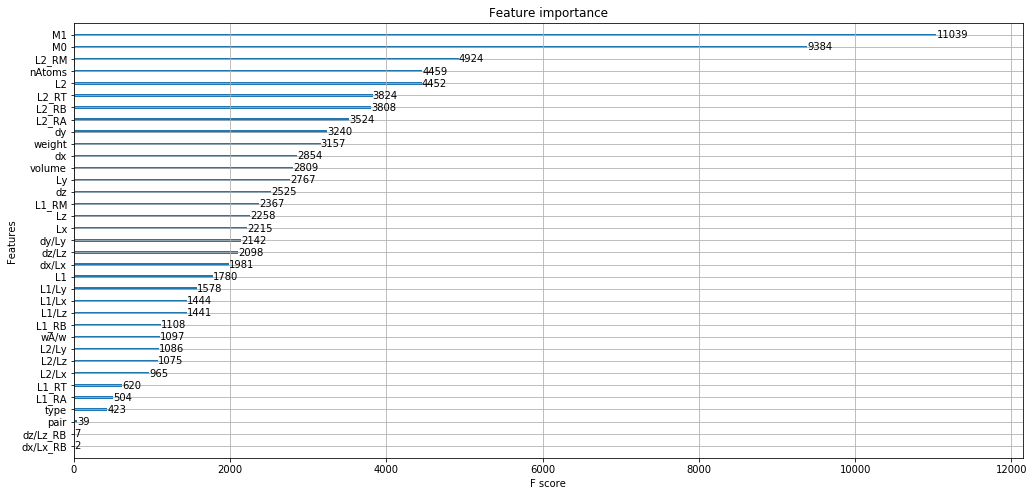

In [21]:
f, ax = plt.subplots(1,1, figsize=(17,8))
xgb.plot_importance(model, ax)

In [22]:
predictions = dict()

predictions['train'] = model.predict(X['train'])
predictions['valid'] = model.predict(X['valid'])
predictions['infer'] = model.predict(X['infer'])

In [23]:
metric(y['train'], predictions['train'], X['train']['type'])

0.498451469596639

In [24]:
metric(y['valid'], predictions['valid'], X['valid']['type'])

0.49763941223703284

In [25]:
submission = {
    'id' : pd.read_csv('../input/test.csv', index_col='id').index,
    'scalar_coupling_constant' : predictions['infer']
}

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [26]:
submission = pd.DataFrame(submission)
submission.to_csv('submision_12.csv', index=False)

In [27]:
submission.head()

,id,scalar_coupling_constant
0,4658147,14.104448
1,4658148,194.247223
2,4658149,2.361309
3,4658150,194.247223
4,4658151,14.104448
